In [1]:
# -*- coding: utf-8 -*-
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the Simargl 2022 dataset.
# implemented Adavance Ensamble Learning Techniques: Stacking

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder



/tmp/ipykernel_2486677/635838729.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-05 11:58:54.388941: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 11:58:54.507289: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 11:5

In [2]:
# Load the cleaned Simargl 2022 dataset
df = pd.read_csv(
    '/home/ibibers@ads.iu.edu/IDS_Datasets/Combined_datasets/Simargl_cleaned_dataset.csv')
tf.keras.backend.clear_session()

In [3]:
# Set the desired number of records for 'Normal' and 'Denial of Service' labels
desired_records_normal = 500000  # Change this to your desired number for 'Normal'
desired_records_dos = 3000000  # Change this to your desired number for 'Denial of Service'

# Filter data for 'Normal' and 'Denial of Service'
subset_df_normal = df[df['ALERT'] == 'Normal']
subset_df_dos = df[df['ALERT'] == 'Denial of Service']

# Sample the desired number of records from each class
subset_df_normal_sampled = subset_df_normal.sample(n=desired_records_normal, random_state=42)
subset_df_dos_sampled = subset_df_dos.sample(n=desired_records_dos, random_state=42)

# Combine the subsets with the rest of the data
final_subset = pd.concat([subset_df_normal_sampled, subset_df_dos_sampled, df[df['ALERT'] != 'Normal'][df['ALERT'] != 'Denial of Service']])

# Optional: Shuffle the final subset
final_subset = final_subset.sample(frac=1, random_state=42)


/tmp/ipykernel_2486677/364247859.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_subset = pd.concat([subset_df_normal_sampled, subset_df_dos_sampled, df[df['ALERT'] != 'Normal'][df['ALERT'] != 'Denial of Service']])


In [4]:
dropped_df = ['ALERT']
X = final_subset.drop(dropped_df, axis=1)
y = final_subset['ALERT']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


In [5]:
# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Dimensionality Reduction using PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [6]:

# Initialize MirroredStrategy for GPU acceleration
strategy = tf.distribute.MirroredStrategy()

# Train the models
with strategy.scope():
    # the base models
    rf_model = RandomForestClassifier()
    nn_model = MLPClassifier()
    lr_model = LogisticRegression()
    dst_model = DecisionTreeClassifier()

    # Build a pipeline for each model with PCA
    rf_pipeline = Pipeline([('pca', PCA(n_components=0.95)), ('rf', rf_model)])
    nn_pipeline = Pipeline([('pca', PCA(n_components=0.95)), ('nn', nn_model)])
    lr_pipeline = Pipeline([('pca', PCA(n_components=0.95)), ('lr', lr_model)])
    dst_pipeline = Pipeline([('pca', PCA(n_components=0.95)), ('dst', dst_model)])

    meta_model = DecisionTreeClassifier()
    
    from sklearn.ensemble import StackingClassifier
    # Stack models using StackingClassifier

      # Stack models using LightGBM
    stacked_model = StackingClassifier(estimators=[
        ('rf', rf_pipeline),
        ('nn', nn_pipeline),
        ('lr', lr_pipeline),
        ('dst', dst_pipeline),
    ], final_estimator=meta_model)

    # Train the stacked model
    stacked_model.fit(X_train_pca, y_train)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2024-03-05 12:00:19.603614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45551 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:67:00.0, compute capability: 8.6
2024-03-05 12:00:19.604248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 45492 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:68:00.0, compute capability: 8.6
/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

In [7]:
# Make predictions with the stacked model
stacked_pred_encoded = stacked_model.predict(X_test_pca)

In [9]:
# Evaluate the model
accuracy = accuracy_score(y_test, stacked_pred_encoded)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9999824007123149


In [10]:
# Use inverse_transform to get original labels
y_pred = label_encoder.inverse_transform(stacked_pred_encoded)
y_test_labels = label_encoder.inverse_transform(y_test)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Denial of Service       1.00      1.00      1.00    600000
          Malware       1.00      1.00      1.00       114
           Normal       1.00      1.00      1.00    100000
    Port Scanning       1.00      1.00      1.00    834039

         accuracy                           1.00   1534153
        macro avg       1.00      1.00      1.00   1534153
     weighted avg       1.00      1.00      1.00   1534153



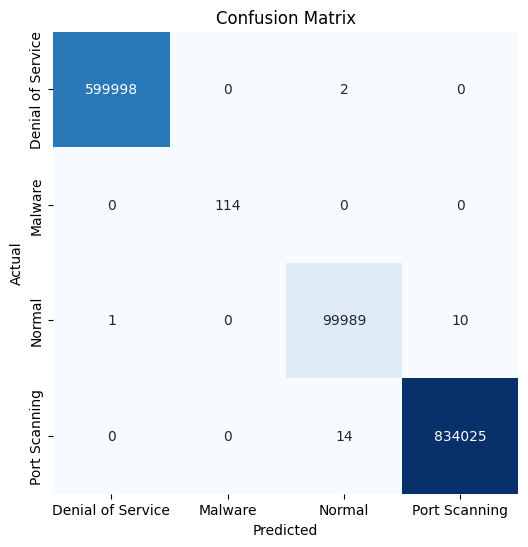

In [11]:
# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test_labels, y_pred)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate(
    (y_test_labels, y_pred)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_2486677/548402338.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance.values,


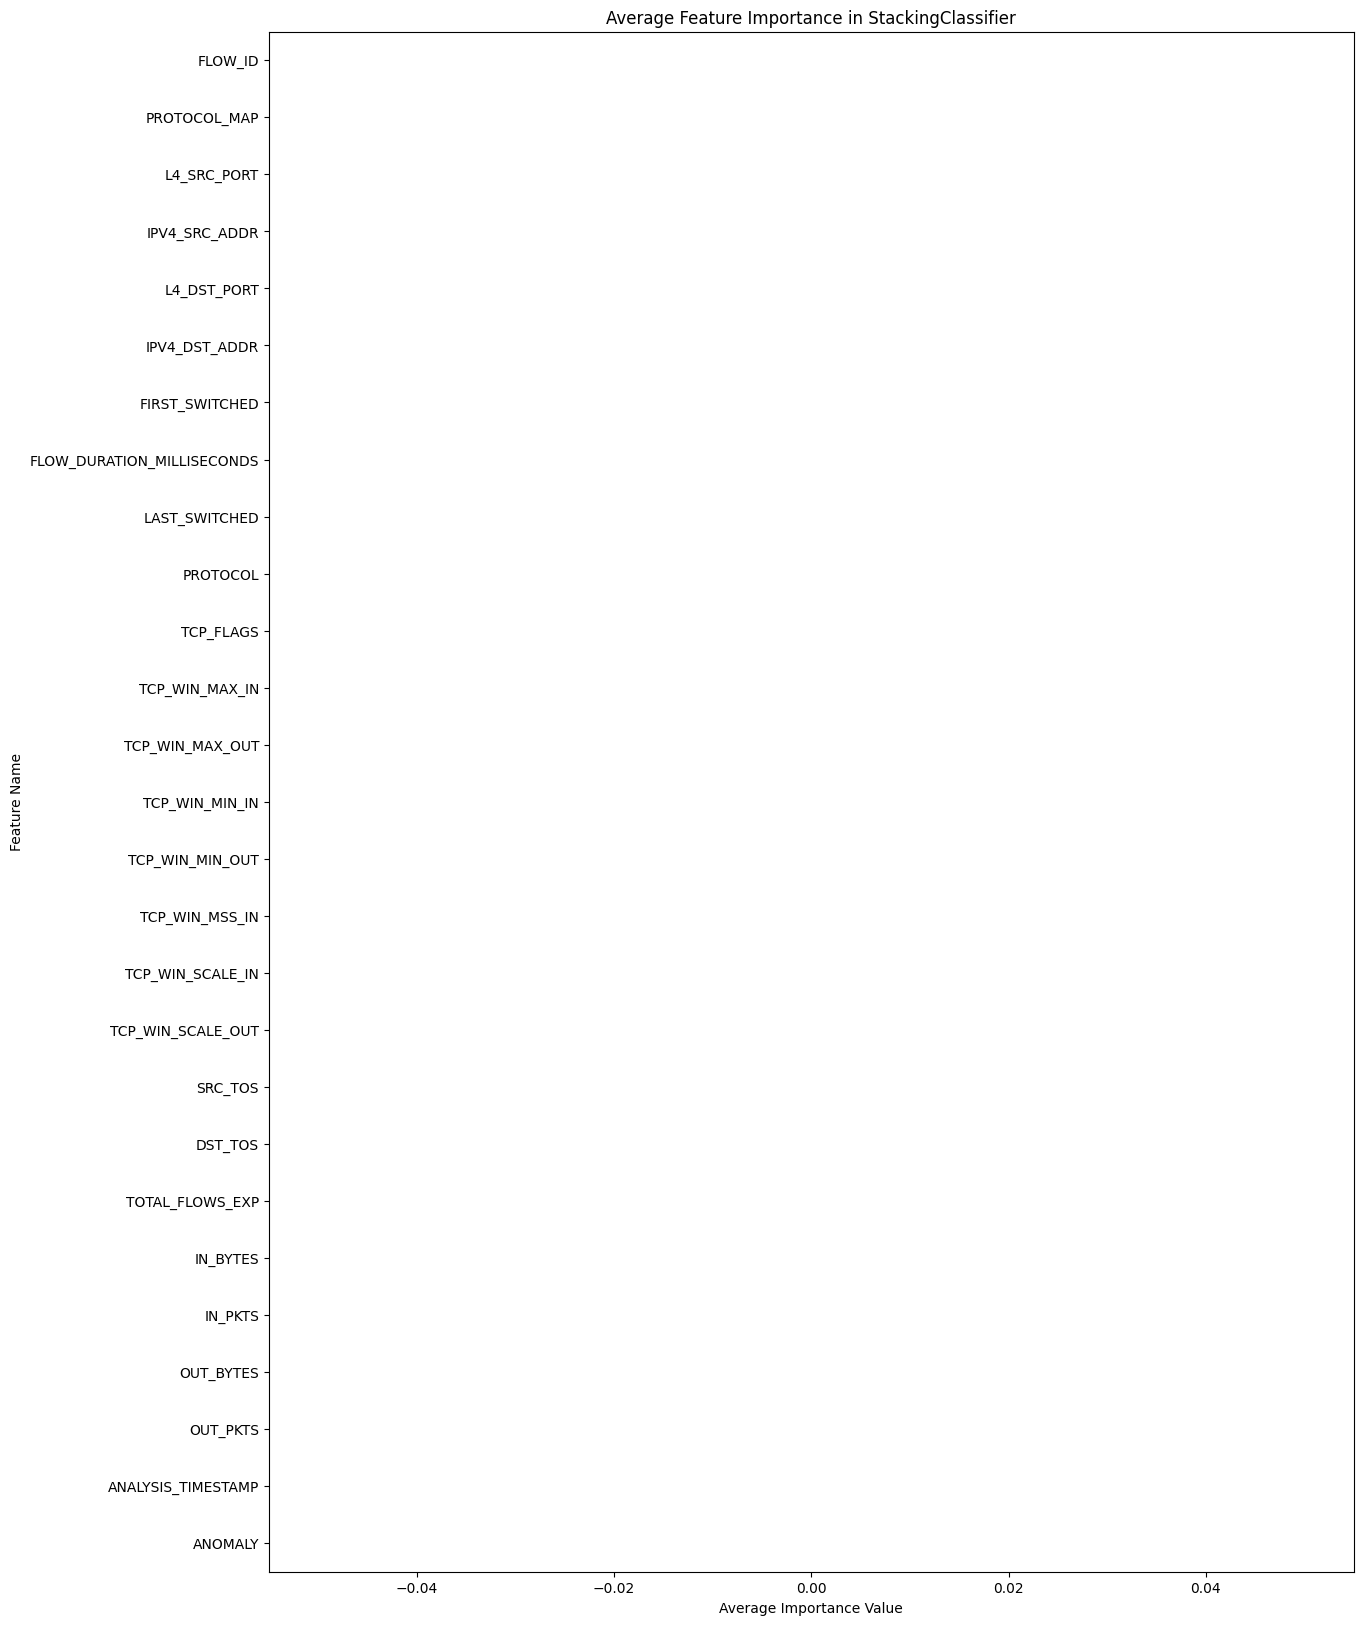

In [12]:
# Extract feature importances from base models
base_models_importances = {}

for name, model in stacked_model.named_estimators_.items():
    if hasattr(model, 'feature_importances_'):
        base_models_importances[name] = model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame(base_models_importances, index=X.columns)

# Calculate average feature importance across base models
average_importance = importance_df.mean(axis=1)

# Sort features by average importance
sorted_importance = average_importance.sort_values(ascending=False)

# Visualize the feature importances
plt.figure(figsize=(14, 20))
sns.barplot(x=sorted_importance.values,
            y=sorted_importance.index, palette='mako')
plt.xlabel('Average Importance Value')
plt.ylabel('Feature Name')
plt.title('Average Feature Importance in StackingClassifier')
plt.show()